<a href="https://colab.research.google.com/github/StevenKim1105/StevenKim1105/blob/main/mnist_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Simple CNN example on the MNIST dataset
# Two conv layers, handwriting classification
import os
import random
import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset


In [2]:

# Hyperparameters adjustable to get optimal results
EPOCH = 5 # Total epochs for training
BATCH_SIZE = 50 # Batchsize
LR = 0.001 # Learning rate
NFILTER = [16,32] # Number of filters for each conv layer
KSIZE = [3,5] # kernel size for each layer,
STRIDE = [1,1] # Stride
PADDING = [1,2] # PADDING
POOLSIZE = [2,2] # Pooling size

# Download MNIST dataset from torchvision
Download_Minist = True
if os.path.exists('./mnist/'):
    Download_Minist = False # dataset exist, no need to download again
train_data = torchvision.datasets.MNIST(
    root='./mnist/',
    train=True,  # True for training and false for test dataset
    download=Download_Minist,  # True for download data, False for having downloaded
)


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist/MNIST/raw



In [3]:

# To speed up training, randomly select 10000 from total 60000 images for training
trainNum = train_data.train_data.size()[0] #60000
sampleInd = random.sample(range(0, trainNum), 10000)
train_x = torch.unsqueeze(train_data.train_data, dim=1).type(torch.FloatTensor)[sampleInd,:] # select 10000 images for training
                                                                                             # size [10000, 1, 28, 28]
train_x = train_x/255   # normalize images from [0, 255] to [0, 1.0]
train_y = train_data.train_labels[sampleInd]
# Using dataloader for mini-batch organization, each batch is of shape (BATCH_SIZE, 1, 28, 28)
train_set = TensorDataset(train_x, train_y)
train_loader = DataLoader(dataset=train_set, batch_size=BATCH_SIZE, shuffle=True)

# To speed up select first 1000 samples from testing dataset to do test
test_data = torchvision.datasets.MNIST(root='./mnist/', train=False)
test_x = torch.unsqueeze(test_data.test_data, dim=1).type(torch.FloatTensor)[0:1000]/255
test_y = test_data.test_labels[0:1000]


/usr/local/lib/python3.8/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.8/dist-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.8/dist-packages/torchvision/datasets/mnist.py:80: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.8/dist-packages/torchvision/datasets/mnist.py:70: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [4]:
test_x.shape

torch.Size([1000, 1, 28, 28])

In [5]:

# The function to calculate the output size of Conv layer
def calConvSize(lin, kernel, stride, padding=0, dilation=1):
    lout = (lin + 2 * padding - dilation * (kernel - 1) - 1) / stride + 1
    return int(lout)
# The function to calculate the output size of pooling layer
def calPoolSize(lin, kernel, stride=None, padding=0, dilation=1):
    if stride is None:
        stride = kernel
    lout = (lin + 2 * padding - dilation * (kernel - 1) - 1) / stride + 1
    return int(lout)

class CNN(nn.Module):
    # Two conv layers CNN network
    def __init__(self, nfilter=[16,32], kernelsize=[5,5], stride=[1,1], padding=[2,2], poolsize=[2,2]):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(         # input shape (1, 28, 28)
            nn.Conv2d(
                in_channels=1,              # input channel number = 1
                out_channels=nfilter[0],    # filter number == output channel number
                kernel_size=kernelsize[0],  # filter size
                stride=stride[0],           # filter movement/step stride
                padding=padding[0],         # padding size
            ),
            nn.ReLU(),                      # activation function
            nn.MaxPool2d(kernel_size=poolsize[0]),    # max pooling
        )
        Lout = calConvSize(lin=28, kernel=kernelsize[0], stride=stride[0], padding=padding[0]) # conv output size
        Lout = calPoolSize(lin=Lout, kernel=poolsize[0]) # pooling output size
        self.conv2 = nn.Sequential(
            nn.Conv2d(nfilter[0], nfilter[1], kernelsize[1], stride[1], padding[1]),
            nn.ReLU(),
            nn.MaxPool2d(poolsize[1]),
        )
        Lout = calConvSize(lin=Lout, kernel=kernelsize[1], stride=stride[1], padding=padding[1]) # conv output size
        Lout = calPoolSize(lin=Lout, kernel=poolsize[1]) # pooling output
        self.out = nn.Linear(nfilter[1] * Lout * Lout, 10)   # fully connected layer, output 10 classes

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)           # flatten the output of conv2 to fully connected layer
        output = self.out(x)
        return output    # return 10 scores



In [8]:

cnn = CNN(nfilter=NFILTER, kernelsize=KSIZE, stride=STRIDE, padding=PADDING, poolsize=POOLSIZE) # Define network
print(cnn)  # net architecture

optimizer = torch.optim.Adam(cnn.parameters(), lr=LR)   # optimize all cnn parameters
loss_fun = nn.CrossEntropyLoss()



CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)


In [ ]:
len(list(cnn.parameters()))

6

In [9]:

# training and testing
EPOCH=5
for epoch in range(EPOCH):
    for step, (b_x, b_y) in enumerate(train_loader):   # Iterate for each minibatch
        output = cnn(b_x)              # cnn output
        loss = loss_fun(output, b_y)   # cross entropy loss
        optimizer.zero_grad()           # clear gradients for this training step
        loss.backward()                 # backpropagation, compute gradients
        optimizer.step()                # apply gradients

        if step % 50 == 0:
            test_output = cnn(test_x)
            pred_y = torch.max(test_output, 1)[1].data.numpy()
            accuracy = float((pred_y == test_y.data.numpy()).astype(int).sum()) / float(test_y.size(0))
            print('Epoch: ', epoch, '| Train loss: %.4f' % loss.data.numpy(), '| Test accuracy: %.2f' % accuracy)


Epoch:  0 | Train loss: 2.2983 | Test accuracy: 0.12
Epoch:  0 | Train loss: 0.5492 | Test accuracy: 0.84
Epoch:  0 | Train loss: 0.2765 | Test accuracy: 0.89
Epoch:  0 | Train loss: 0.3244 | Test accuracy: 0.93
Epoch:  1 | Train loss: 0.2205 | Test accuracy: 0.94
Epoch:  1 | Train loss: 0.3571 | Test accuracy: 0.93
Epoch:  1 | Train loss: 0.1146 | Test accuracy: 0.94
Epoch:  1 | Train loss: 0.1490 | Test accuracy: 0.96
Epoch:  2 | Train loss: 0.1719 | Test accuracy: 0.96
Epoch:  2 | Train loss: 0.0761 | Test accuracy: 0.96
Epoch:  2 | Train loss: 0.1988 | Test accuracy: 0.97
Epoch:  2 | Train loss: 0.0549 | Test accuracy: 0.96
Epoch:  3 | Train loss: 0.0878 | Test accuracy: 0.97
Epoch:  3 | Train loss: 0.0159 | Test accuracy: 0.97
Epoch:  3 | Train loss: 0.0831 | Test accuracy: 0.97
Epoch:  3 | Train loss: 0.0691 | Test accuracy: 0.97
Epoch:  4 | Train loss: 0.0310 | Test accuracy: 0.97
Epoch:  4 | Train loss: 0.0218 | Test accuracy: 0.97
Epoch:  4 | Train loss: 0.1128 | Test accuracy

[7 2 1 0 4 1 4 9 5 9] prediction number
[7 2 1 0 4 1 4 9 5 9] real number


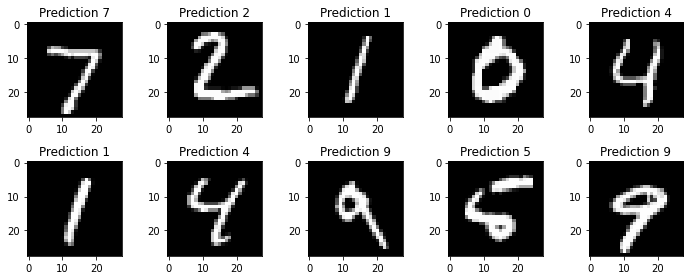

In [10]:

# print 10 predictions from test data
test_output = cnn(test_x[:10])
pred_y = torch.max(test_output, 1)[1].data.numpy()
print(pred_y, 'prediction number')
print(test_y[:10].numpy(), 'real number')
# plot these 10 images
fig, axes = plt.subplots(2,5, figsize=(10,4), tight_layout=True)
axes = axes.flat
for ii in range(len(axes)):
    ax = axes[ii]
    ax.imshow(test_x[:10].numpy()[ii,0,:], cmap='gray')
    ax.set_title('Prediction %i' % pred_y[ii])

torch.Size([60000, 28, 28])
torch.Size([60000])


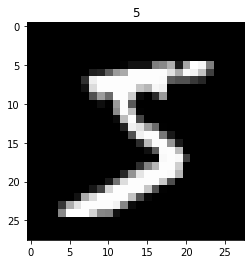

In [11]:

# Print one example
print(train_data.train_data.size())                 # (60000, 28, 28) 60000 images in total
print(train_data.train_labels.size())               # (60000)
plt.imshow(train_data.train_data[0].numpy(), cmap='gray')
plt.title('%i' % train_data.train_labels[0])
plt.show()